In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
print(tf.__version__)

2.12.0


In [3]:
train_dir= Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths=list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir= Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

In [5]:
test_dir= Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths=list(test_dir.glob(r'**/*.jpg'))

In [6]:
def image_processing(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
             for i in range(len(filepath))]
    filepath =pd.Series(filepath,name='Filepath').astype(str)
    labels=pd.Series(labels,name='Label')
    
    df=pd.concat([filepath,labels],axis=1)
    
    df=df.sample(frac=1).reset_index(drop = True)
    
    return df


In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
#print(f'Training Size: {train_df.size}\n')
print(f'test: {test_df.shape[0]}\n')
#print(f'Test Size {train_df.size}\n')
print(f'Validation: {val_df.shape[0]}\n')
#print(f'Val Size: {train_df.size}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels:{train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

test: 334

Validation: 334

Number of different labels: 36

Labels:['jalepeno' 'mango' 'watermelon' 'potato' 'cauliflower' 'paprika' 'orange'
 'tomato' 'turnip' 'pomegranate' 'chilli pepper' 'lettuce' 'sweetcorn'
 'cabbage' 'carrot' 'soy beans' 'corn' 'spinach' 'peas' 'onion' 'grapes'
 'raddish' 'sweetpotato' 'garlic' 'banana' 'beetroot' 'eggplant' 'pear'
 'kiwi' 'capsicum' 'cucumber' 'ginger' 'apple' 'bell pepper' 'pineapple'
 'lemon']


In [9]:
train_df.head(5)

,Filepath,Label
0,../input/fruit-and-vegetable-image-recognition...,jalepeno
1,../input/fruit-and-vegetable-image-recognition...,mango
2,../input/fruit-and-vegetable-image-recognition...,watermelon
3,../input/fruit-and-vegetable-image-recognition...,potato
4,../input/fruit-and-vegetable-image-recognition...,cauliflower


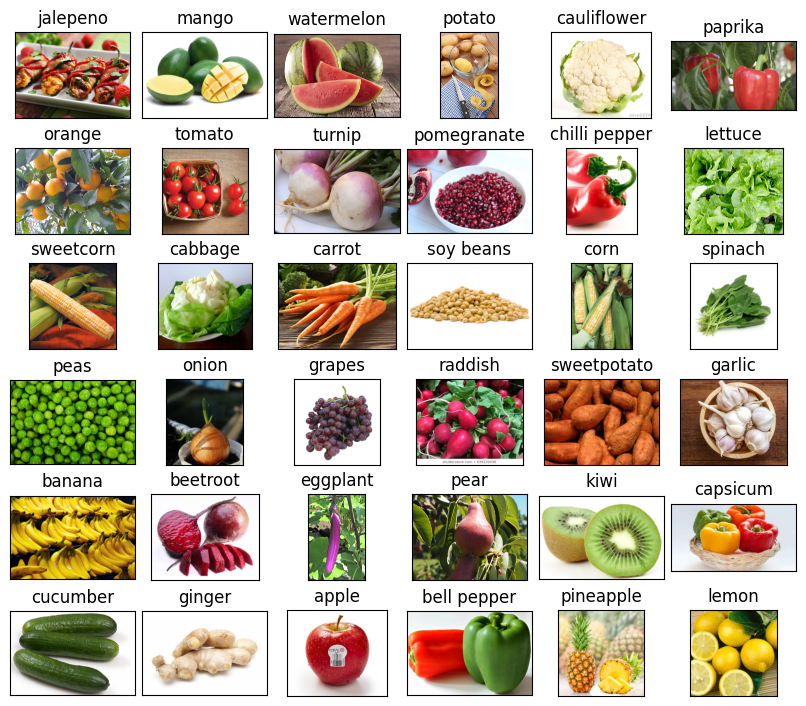

In [10]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes =plt.subplots(nrows=6,ncols=6,figsize=(8,7),
                        subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i],fontsize =12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',  # Corrected to match your DataFrame column name
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 2780 validated image filenames belonging to 36 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
dataframe=val_df,
x_col='Filepath',
y_col='Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=0,
rotation_range=30,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest"       
)

Found 334 validated image filenames belonging to 36 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False      
)

Found 334 validated image filenames belonging to 36 classes.


In [15]:
#Different
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
inputs = pretrained_model.input

x=tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x=tf.keras.layers.Dense(128, activation='relu')(x)

outputs= tf.keras.layers.Dense(36, activation='softmax')(x)

model=tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
    )

Epoch 1/5
87/87 [==============================] - 157s 2s/step - loss: 1.7559 - accuracy: 0.5216 - val_loss: 0.4294 - val_accuracy: 0.8802
Epoch 2/5
87/87 [==============================] - 132s 2s/step - loss: 0.5699 - accuracy: 0.8115 - val_loss: 0.2902 - val_accuracy: 0.9072
Epoch 3/5
87/87 [==============================] - 131s 1s/step - loss: 0.3405 - accuracy: 0.8874 - val_loss: 0.2447 - val_accuracy: 0.9431
Epoch 4/5
87/87 [==============================] - 130s 1s/step - loss: 0.2145 - accuracy: 0.9324 - val_loss: 0.1881 - val_accuracy: 0.9461
Epoch 5/5
87/87 [==============================] - 132s 2s/step - loss: 0.1480 - accuracy: 0.9583 - val_loss: 0.2258 - val_accuracy: 0.9222


In [17]:
pred= model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels=(train_images.class_indices)
labels =dict((v,k) for k,v in labels.items())
pred1= [labels[k] for k in pred]
pred1

11/11 [==============================] - 20s 2s/step


['onion',
 'bell pepper',
 'sweetpotato',
 'lemon',
 'sweetcorn',
 'chilli pepper',
 'lemon',
 'tomato',
 'mango',
 'bell pepper',
 'spinach',
 'watermelon',
 'potato',
 'pomegranate',
 'jalepeno',
 'beetroot',
 'ginger',
 'apple',
 'cucumber',
 'tomato',
 'potato',
 'chilli pepper',
 'lemon',
 'sweetcorn',
 'pineapple',
 'grapes',
 'eggplant',
 'mango',
 'watermelon',
 'cucumber',
 'pineapple',
 'paprika',
 'grapes',
 'peas',
 'carrot',
 'cabbage',
 'apple',
 'bell pepper',
 'tomato',
 'cabbage',
 'soy beans',
 'onion',
 'orange',
 'paprika',
 'garlic',
 'tomato',
 'cucumber',
 'spinach',
 'jalepeno',
 'sweetpotato',
 'beetroot',
 'orange',
 'bell pepper',
 'cabbage',
 'corn',
 'watermelon',
 'garlic',
 'lettuce',
 'sweetpotato',
 'pomegranate',
 'pineapple',
 'sweetpotato',
 'sweetcorn',
 'kiwi',
 'kiwi',
 'raddish',
 'cabbage',
 'kiwi',
 'eggplant',
 'kiwi',
 'peas',
 'raddish',
 'pineapple',
 'spinach',
 'bell pepper',
 'apple',
 'potato',
 'turnip',
 'soy beans',
 'sweetcorn',
 'p

In [18]:
def output(location):
    img =load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/225
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class=answer.argmax(axis=-1)
    y= " ".join(str(x) for x in y_class)
    y=int(y)
    res=labels[y] 
    return res
    

In [19]:
img=output('../input/fruit-and-vegetable-image-recognition/train/cucumber/Image_42.png')

img

1/1 [==============================] - 1s 846ms/step


'cucumber'

In [20]:
import os
print(os.getcwd())

/kaggle/working


In [21]:
model.save("FV.h5")
print(os.getcwd())

/kaggle/working


In [22]:
import os
files = os.listdir('/kaggle/working')
print(files)

['FV.h5', '__notebook__.ipynb']
